In [284]:
import numpy as np
import pandas as pd
import missingno as msno
import time
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime

%matplotlib inline

In [255]:
sensor_descriptions = pd.read_csv('Sensors_from_purpleair.csv')
sensor_data = pd.read_csv('combined_purpleair_bayarea_2.5umPerdl_2018_2020.csv')
sensor_data = sensor_data.sort_values(by='created_at')


In [259]:
print(sensor_descriptions.shape)
print(sensor_data.shape)

display(sensor_descriptions.head())
display(sensor_data.head(3))
display(sensor_data.tail(3))

(13889, 44)
(897, 910)


,id,parent,lat,lon,name,location_type,pm_2.5,temp_f,temp_c,humidity,...,last_update_check,created,uptime,is_owner,10min_avg,30min_avg,1hour_avg,6hour_avg,1day_avg,1week_avg
0,14633,NaN,37.275561,-121.964134,Hazelwood canary,outside,3.07,102.0,38.888889,8.0,...,NaN,NaN,NaN,False,3.34,3.02,2.62,3.85,6.66,21.70
1,25999,NaN,30.053808,-95.494643,Villages of Bridgestone AQI,outside,16.16,97.0,36.111111,40.0,...,NaN,NaN,NaN,False,15.75,15.30,15.21,18.48,18.74,17.81
2,14091,NaN,37.883620,-122.070087,WC Hillside,outside,0.91,92.0,33.333333,11.0,...,NaN,NaN,NaN,False,1.09,1.18,1.31,2.91,5.90,28.49
3,42073,NaN,47.185173,-122.176855,#1,outside,6.47,64.0,17.777778,50.0,...,NaN,NaN,NaN,False,6.21,5.46,4.97,3.57,3.36,18.67
4,53069,NaN,47.190197,-122.177992,#2,outside,6.66,77.0,25.000000,33.0,...,NaN,NaN,NaN,False,5.84,5.15,4.73,3.49,3.31,19.81


,Unnamed: 0,created_at,19257,15553,8408,13143,22337,25451,20873,15235,...,6428,1208,18399,20005,18811,20143,20469,23189,3277,21235
0,758,2018-05-01 00:00:00+00:00,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.28,NaN
1,759,2018-05-02 00:00:00+00:00,NaN,NaN,1.21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.04,NaN
2,760,2018-05-03 00:00:00+00:00,NaN,NaN,1.58,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.14,NaN


,Unnamed: 0,created_at,19257,15553,8408,13143,22337,25451,20873,15235,...,6428,1208,18399,20005,18811,20143,20469,23189,3277,21235
894,696,2020-10-11 00:00:00+00:00,2.07,2.24,NaN,1.34,3.37,NaN,4.11,1.15,...,1.38,NaN,NaN,1.47,1.91,1.04,1.49,NaN,1.55,1.70
895,697,2020-10-12 00:00:00+00:00,4.68,5.58,NaN,2.73,4.79,NaN,6.76,2.08,...,2.88,NaN,NaN,3.03,4.49,2.74,3.12,NaN,2.77,4.19
896,698,2020-10-13 00:00:00+00:00,6.77,3.39,NaN,1.86,5.79,NaN,6.87,2.12,...,3.78,NaN,NaN,3.10,5.05,1.92,3.14,NaN,3.82,3.65


<AxesSubplot:>

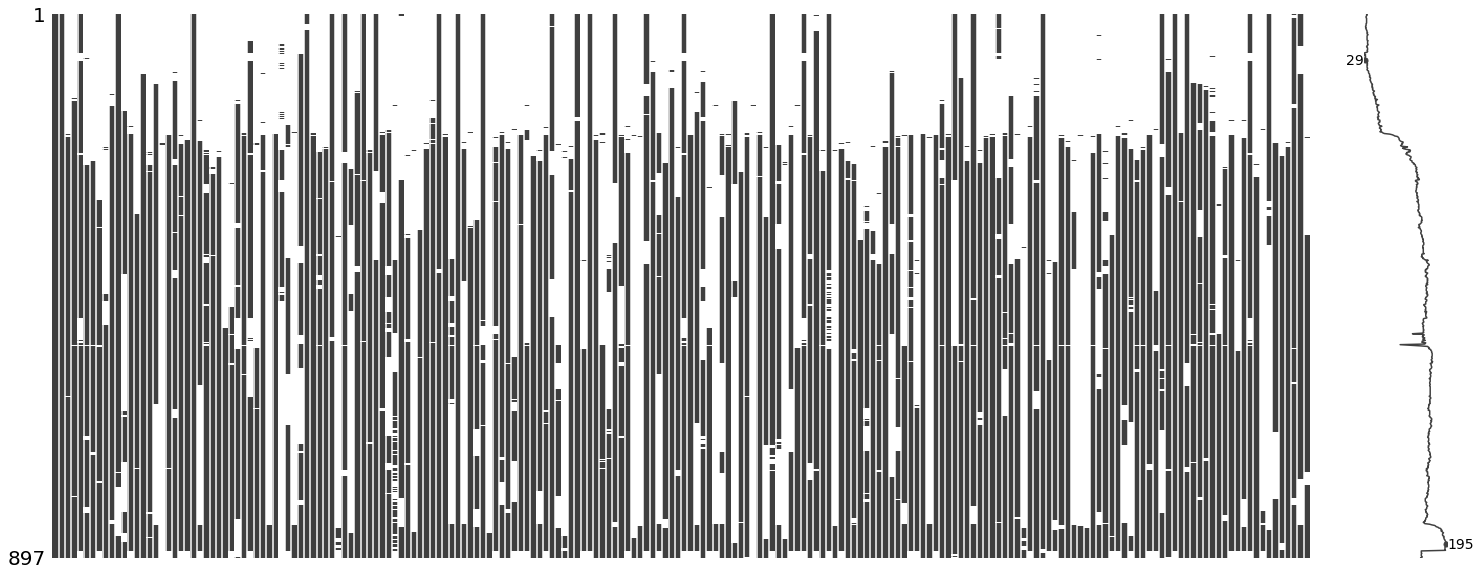

In [3]:
msno.matrix(sensor_data.iloc[:, : 200])

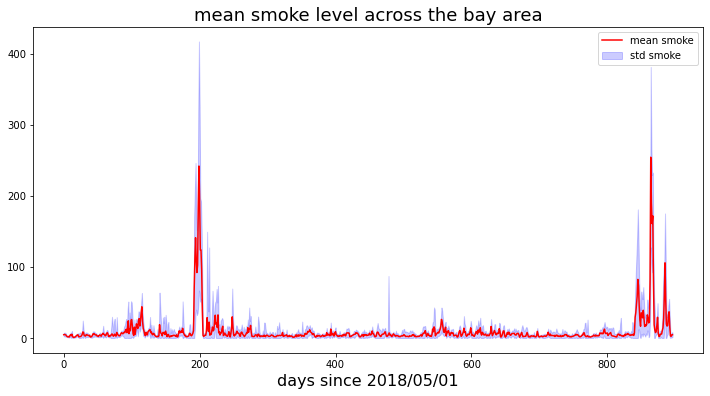

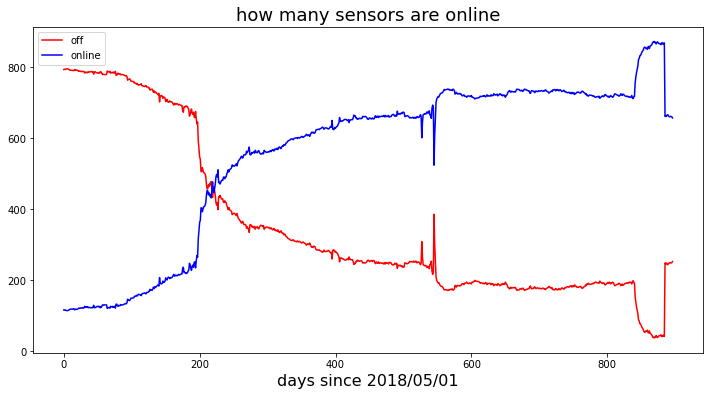

In [375]:
def plot_mean():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title('mean smoke level across the bay area', fontsize=18)
    std_smoke = sensor_data.iloc[:, 2:].std(axis=1)
    mean_smoke = sensor_data.iloc[:, 2:].mean(axis=1)
    x = np.arange(len(std_smoke))
    #plt.yscale('log')

    ax.plot(x, mean_smoke, c='r', label='mean smoke')
    ax.fill_between(x, 
                    mean_smoke + std_smoke, 
                    np.maximum(mean_smoke - std_smoke, np.zeros(len(x))), 
                    color='blue', 
                    alpha=0.2,
                    label='std smoke')
    ax.legend()
    ax.set_xlabel('days since 2018/05/01', fontsize=16)

def plot_missing():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title('how many sensors are online', fontsize=18)
    
    missing = sensor_data.isna().sum(axis=1)
    present = sensor_data.notna().sum(axis=1)
    x = np.arange(len(missing))
    ax.plot(x, missing, label='off', c='r')
    ax.plot(x, present, label='online', c='b')
    ax.legend()
    ax.set_xlabel('days since 2018/05/01', fontsize=16)
    
    
plot_mean()
plot_missing()

Construct a 3D tensor, where the 'vertical' dimension is time (each slice is a single day here) and where the row/column dimensions are a list of smoke/latitude/longitude.

In [260]:

def take_time_slice_give_map(smoke_time_slice_series, sensor_desc_df):
    
    id_lat_lon_df = sensor_desc_df[['id', 'lat', 'lon']]
    smoke_time_slice_series = smoke_time_slice_series.rename('smoke')
    #smoke_time_slice_series = smoke_time_slice_series.fillna(-10.0)
    smoke_time_slice_df = pd.DataFrame(smoke_time_slice_series[2:]) # first elements skipped are datetime and day.
    smoke_time_slice_df = smoke_time_slice_df.rename(columns={0: 'smoke'})
    smoke_time_slice_df['id'] = smoke_time_slice_df.index.astype('int64') # turn index into a column
    
    df_merged = reduce(lambda left, right: pd.merge(
        left, 
        right, 
        on=['id'],
        how='left'), [smoke_time_slice_df, id_lat_lon_df])
    
    return df_merged


time_slice_smoke = []
for index, row in sensor_data.iterrows():
    time_slice_smoke_map = take_time_slice_give_map(
        row, 
        sensor_desc_df = sensor_descriptions)
    time_slice_smoke.append(time_slice_smoke_map)

#sample_map_df = take_time_slice_give_map(sensor_data.iloc[700:701, 2: ], sensor_desc_df = sensor_descriptions)
print(len(time_slice_smoke))

897


In [261]:
sum_total = 0
for df in time_slice_smoke:
    sum_total += df.memory_usage().sum() * (1/(10**6))
    
print("Smoke tensor (lat lon datestamp smoke) takes up {} MB.".format(sum_total))

Smoke tensor (lat lon datestamp smoke) takes up 32.57903999999998 MB.


In [262]:
print(sensor_data.columns)
#sensor_data = sensor_data.rename(columns={'Unnamed: 0': 'id'})
sensor_data = sensor_data.sort_values(by='created_at')

Index(['Unnamed: 0', 'created_at', '19257', '15553', '8408', '13143', '22337',
       '25451', '20873', '15235',
       ...
       '6428', '1208', '18399', '20005', '18811', '20143', '20469', '23189',
       '3277', '21235'],
      dtype='object', length=910)


```make_CA_plot()``` creates a single map on a given day of the bay area.

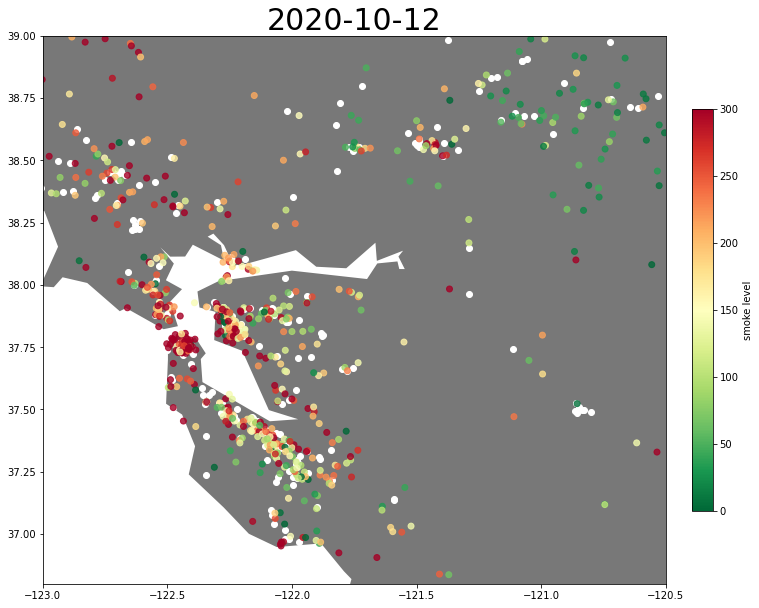

In [392]:
def parse_day_str(day_str):
    date = (day_str.split('+'))[0]
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    date = "{}".format(date.date())
    return date

def make_CA_plot(df, day_str, size=(12, 12)):
    #print(day_str)
    
    null_smoke_df = df[df['smoke'].isnull()]
    not_null_smoke_df = df[df['smoke'].notnull()]
    
    usa = gpd.read_file('states.shp')
    fig, ax = plt.subplots(figsize=size)

    usa[usa.STATE_ABBR == 'CA'].plot(ax=ax, alpha=0.9, color='dimgrey')
    
    vmin, vmax = 0, 300
    not_null_point_data = gpd.GeoDataFrame(
        not_null_smoke_df, 
        geometry=gpd.points_from_xy(not_null_smoke_df.lon, not_null_smoke_df.lat))
    
    null_point_data = gpd.GeoDataFrame(
        null_smoke_df, 
        geometry=gpd.points_from_xy(null_smoke_df.lon, null_smoke_df.lat))
        
    # # create the colorbar
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn_r')

    null_point_data.plot(ax=ax, c='white', label='No data', legend=True)
    not_null_point_data.plot(ax=ax, 
                             legend=False, 
                             column='smoke', 
                             cmap='RdYlGn_r', 
                             alpha=0.8,
                            norm=plt.Normalize(vmin=vmin, vmax=vmax))

    ax.set_xlim(-123, -120.5)
    ax.set_ylim(36.8, 39)  

    # add colorbar
    ax_cbar = fig.colorbar(cbar, ax=ax, fraction=0.03, pad=0.04)
    # add label for the colorbar
    ax_cbar.set_label('smoke level')
    
#     title = (day_str.split('+'))[0]
#     title = datetime.strptime(title, '%Y-%m-%d %H:%M:%S')
#     title = "{}".format(title.date())
    ax.set_title(parse_day_str(day_str), fontsize=30)
    
    return fig

    
x = make_CA_plot(df=time_slice_smoke[895], day_str=sensor_data.created_at[895])

The following loop creates a .png file for each day on the map in the '/visualization' directory. The loop took about 12 minutes to run for all 880 frames on my laptop.

I then used ffmpeg to turn this into a gif; then an mp4 \[from the commandline\]:
```
ffmpeg -framerate 15 -i img%03d.png -f gif out.gif
```

In [389]:
for i, df in enumerate(time_slice_smoke):
    day_str=sensor_data.created_at[i]
    fig = make_CA_plot(df=df, day_str=day_str)
    fig.savefig('./visualization/img{:03d}.png'.format(i), 
              dpi=75, format='png', 
              bbox_inches='tight')
    plt.close()